In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root, minimize
from scipy.optimize import approx_fprime

In [4]:
class Bar1D:
    def __init__(self, initial_u, F3, g0, alpha=1e12):
        self.E = 210e9            
        self.L = 1.0              
        self.num_elems = 4
        self.num_nodes = self.num_elems + 1
        self.x_mid = np.array([0.125, 0.375, 0.625, 0.875])
        self.d_mid = 0.02 + 0.02 * self.x_mid
        self.A_mid = np.pi * (self.d_mid / 2)**2
        self.elem_length = self.L / self.num_elems
        self.F3 = F3
        self.g0 = g0
        self.u_full = np.array(initial_u)
        self.alpha = alpha
    
    def potential_energy(self, u_full):
        du = (u_full[1:] - u_full[:-1]) / self.elem_length 
        energy_elements = 0.5 * self.E * self.A_mid * (du**2) * self.elem_length
        energy = np.sum(energy_elements)
        energy -= self.F3 * u_full[2]
        return energy

    def calculate_u(self, i, x, u_full):
        x_i = i * self.elem_length
        xi = (x - x_i) / self.elem_length  
        N1 = 1 - xi
        N2 = xi
        ux = N1 * u_full[i] + N2 * u_full[i+1]
        dux = (u_full[i+1] - u_full[i]) / self.elem_length
        return ux, dux

    def augmented_potential_energy(self, Y):
        u_full = np.zeros(5)
        u_full[0] = 0.0
        u_full[1:] = Y[:4]
        lam = Y[4]
        return self.potential_energy(u_full) + lam * (self.g0 - u_full[4])
    
    def grad_augmented(self, Y, epsilon=1e-8):
        return approx_fprime(Y, self.augmented_potential_energy, epsilon)
    
    def lagrange_method(self, tol=1e-6):
        u2_guess = self.u_full[1]
        u3_guess = self.u_full[2]
        u4_guess = self.u_full[3]
        u5_guess = self.g0  
        lambda_guess = 0.0
        Y0 = np.array([u2_guess, u3_guess, u4_guess, u5_guess, lambda_guess])
        
        def F(Y):
            return self.grad_augmented(Y)
        
        sol = root(F, Y0, method='hybr', tol=tol)
        if sol.success:
            Y_sol = sol.x
            u_full_sol = np.zeros(5)
            u_full_sol[0] = 0.0
            u_full_sol[1:] = Y_sol[:4]
            lam = Y_sol[4]
            return u_full_sol, lam, self.augmented_potential_energy(Y_sol)
        else:
            raise RuntimeError("Root finding did not converge: " + sol.message)
    
    def penalty_potential_energy(self, Y):
        u_full = np.zeros(5)
        u_full[0] = 0.0            
        u_full[1:] = Y[:4]         
        penalty_term = 0.5 * self.alpha * (self.g0 - u_full[4])**2
        return self.potential_energy(u_full) + penalty_term

    def solve_penalty(self, tol=1e-6):
        Y0 = np.array([self.u_full[1], self.u_full[2], self.u_full[3], self.g0])
        
        res = minimize(self.penalty_potential_energy, Y0, method='BFGS', tol=tol)
        if res.success:
            Y_sol = res.x
            u_full_sol = np.zeros(5)
            u_full_sol[0] = 0.0
            u_full_sol[1:] = Y_sol[:4]
            return u_full_sol, res.fun
        else:
            raise RuntimeError("Penalty minimization did not converge: " + res.message)
        
    def plot_force_displacement(self, F3_range=None):
        if F3_range is None:
            F3_range = np.linspace(0, 80532, 10)
        u_node3_lagrange = []
        u_node3_penalty = []
        F3_orig = self.F3
        for F in F3_range:
            self.F3 = F
            self.u_full = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
            try:
                u_sol, lam, aug_energy = self.lagrange_method(tol=1e-6)
                u_node3_lagrange.append(u_sol[2])
            except RuntimeError as e:
                u_node3_lagrange.append(np.nan)
            
            try:
                u_sol, pen_energy = self.solve_penalty(tol=1e-6)
                u_node3_penalty.append(u_sol[2])
            except RuntimeError as e:
                u_node3_penalty.append(np.nan)
        
        self.F3 = F3_orig

        plt.figure(figsize=(8, 6))
        plt.plot(F3_range, u_node3_lagrange, 'o-', label='Lagrange Method')
        plt.plot(F3_range, u_node3_penalty, 's--', label='Penalty Method')
        plt.xlabel('Applied Force F3 (N)')
        plt.ylabel('Displacement at Node 3 (m)')
        plt.title('Force-Displacement Diagram at Point of Application')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_penalty_interference(self, alpha_range=None):
        if alpha_range is None:
            alpha_range = np.logspace(8, 14, 20)
        interference = []

        alpha_orig = self.alpha

        for a in alpha_range:
            self.alpha = a
            self.u_full = np.array([0.0, 0.0, 0.0, 0.0, self.g0])
            try:
                u_sol, pen_energy = self.solve_penalty(tol=1e-6)
                interference.append(np.abs(self.g0 - u_sol[4]))
            except RuntimeError as e:
                interference.append(np.nan)

        self.alpha = alpha_orig

        plt.figure(figsize=(8, 6))
        plt.semilogx(alpha_range, interference, 'd-', label='Interference Error')
        plt.xlabel('Penalty Stiffness Coefficient α (N/m)')
        plt.ylabel('Interference |g0 - u5| (m)')
        plt.title('Effect of Penalty Stiffness on Constraint Interference')
        plt.legend()
        plt.grid(True, which='both')
        plt.show()

Lagrange Method:
Nodal displacements [u1, u2, u3, u4, u5]:
[0.         0.00012051 0.00020119 0.0001434  0.0001    ]
Lagrange multiplier λ = -40259.0068389002
Augmented potential energy = -10.115845032391825

Penalty Method:
Nodal displacements [u1, u2, u3, u4, u5]:
[0.00000000e+00 1.20501378e-04 2.01180029e-04 1.43390149e-04
 9.99965746e-05]
Penalized potential energy = -10.115648145876014


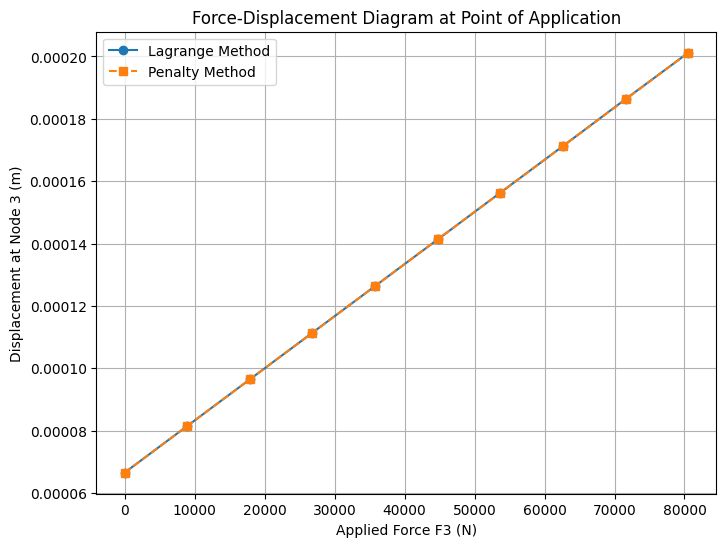

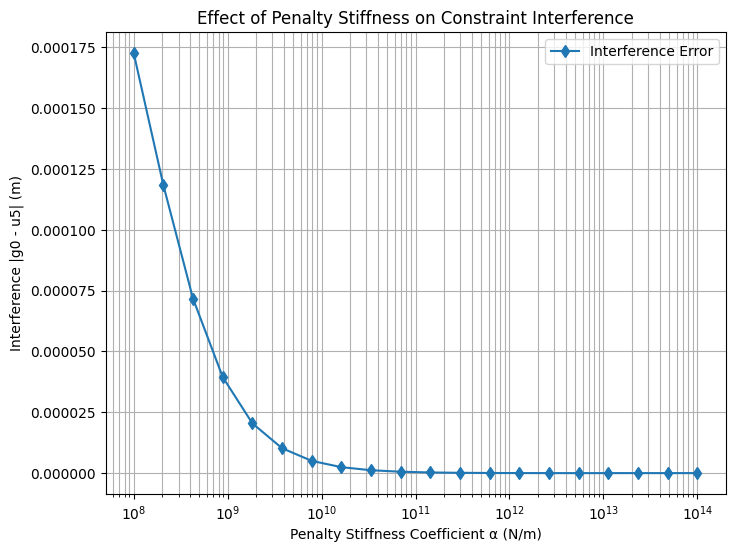

In [5]:
def main():
    initial_u_full = [0.0, 0.0, 0.0, 0.0, 0.0]
    F3 = 80532   
    g0 = 0.0001    
    alpha = 1e13     

    bar = Bar1D(initial_u_full, F3, g0, alpha)

    try:
        u_sol, lam_sol, aug_energy = bar.lagrange_method(tol=1e-6)
        print("Lagrange Method:")
        print("Nodal displacements [u1, u2, u3, u4, u5]:")
        print(u_sol)
        print("Lagrange multiplier λ =", lam_sol)
        print("Augmented potential energy =", aug_energy)
    except RuntimeError as e:
        print(e)
    
    try:
        u_sol, pen_energy = bar.solve_penalty(tol=1e-6)
        print("\nPenalty Method:")
        print("Nodal displacements [u1, u2, u3, u4, u5]:")
        print(u_sol)
        print("Penalized potential energy =", pen_energy)
    except RuntimeError as e:
        print(e)
    
    bar.plot_force_displacement()
    bar.plot_penalty_interference()

if __name__ == "__main__":
    main()